In [1]:
import gpflow
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
from scipy.integrate import solve_ivp, odeint
from gpflow.utilities import print_summary, positive, to_default_float, set_trainable
from invariance_kernels import *
from invariance_functions import *
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '3'

In [11]:
mean = ZeroMean(2)
time_step = 0.01
training_time = 0.1
testing_time = 1

max_x = 2
max_v = 2
n_train = 1
train_starting_position = np.random.uniform(-max_x, max_x, (n_train))
train_starting_velocity = np.random.uniform(-max_v, max_v, (n_train))

print(train_starting_position)
print(train_starting_velocity)
data = get_SHM_data(time_step, training_time, 1e-8, train_starting_position, train_starting_velocity) #switch

[1.36728773]
[-0.89990743]


moi:67.67
known: 82.00
learnt: 79.24
[[-2.30441185e-06]
 [-7.17533130e-02]]
[[ 9.29479659e-06]
 [-7.17593230e-02]]


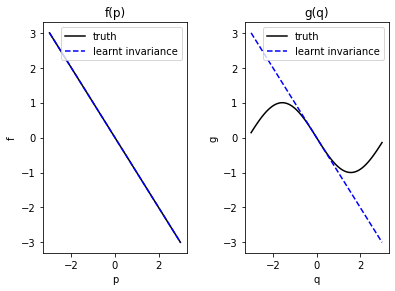

In [12]:

moi, *dump = get_GPR_model(get_MOI(), mean, data, 500)
print("moi:"+format(moi.log_marginal_likelihood().numpy(),".2f"))
jitter = 1e-4
invar_density = 40
invar_range = 3
poly_f_d = 2
poly_g_d = 2
known_kernel = get_invariance_kernel(SHMInvariance, invar_range, invar_density, jitter) #switch
known, *dump = get_GPR_model(known_kernel, mean,data, 500)
print("known: "+format(known.log_marginal_likelihood().numpy(),".2f"))
learnt_kernel = get_parameterised_invariance_kernel(PolynomialInvariance, invar_range, invar_density, jitter, poly_f_d, poly_g_d) #switch
model, fs, gs, coeff = get_GPR_model(learnt_kernel, mean, data, 3000, stored=True)
print("learnt: "+ format(model.log_marginal_likelihood().numpy(),".2f"))
print(learnt_kernel.f_poly.numpy())
print(learnt_kernel.g_poly.numpy())

import matplotlib.pyplot as plt
from numpy.polynomial import polynomial
x = np.linspace(-3,3,100)
multiplier = -learnt_kernel.f_poly.numpy()[1]
f = polynomial.Polynomial(np.squeeze(learnt_kernel.f_poly.numpy()))
g = polynomial.Polynomial(np.squeeze(learnt_kernel.g_poly.numpy()))

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(x, -x, label='truth', color="black")
ax1.plot(x, f(x)/multiplier, "--", color="blue", label='learnt invariance')
ax1.set_title("f(p)")
ax1.set_xlabel("p")
ax1.set_ylabel("f")
ax1.legend()
ax2.set_title("g(q)")
ax2.plot(x, -np.sin(x), color="black", label='truth')
ax2.plot(x, g(x)/multiplier, "--", color="blue",label='learnt invariance')
ax2.legend()
ax2.set_xlabel("q")
ax2.set_ylabel("g")
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)



Text(0.5, 0.92, 'RBF GP Posterior of v')

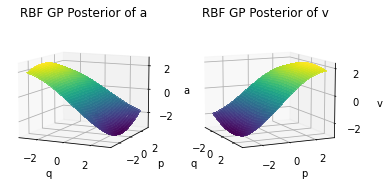

In [15]:
import matplotlib.pyplot as plt
test_range = 3
test_density = 40
test_xs = tf.linspace(-test_range,test_range,test_density)
test_vs = tf.linspace(-test_range,test_range,test_density)
test_xx, test_vv = tf.meshgrid(test_xs, test_vs)
test_points = tf.stack([tf.reshape(test_xx,[-1]), tf.reshape(test_vv,[-1])], axis=1)
pred, var = known.predict_f(test_points) ######switch
X, Y = data
pred_a = pred[:int(pred.shape[0]/2),:]
var_a = var[:int(var.shape[0]/2),:]
pred_v = pred[int(pred.shape[0]/2):,:]
var_v = var[int(var.shape[0]/2):,:]
fig, (ax1, ax2) = plt.subplots(1, 2, subplot_kw={"projection": "3d"})
ax1.plot_surface(test_xx, test_vv, tf.reshape(pred_a, test_xx.shape), cmap="viridis",linewidth=0, antialiased=False, alpha=0.8)
#ax1.plot_surface(test_xx, test_vv, tf.reshape(pred_a, test_xx.shape)+1.96*tf.math.sqrt(tf.reshape(var_a, test_xx.shape)), color="grey",linewidth=0, antialiased=False, alpha=0.4)
#ax1.plot_surface(test_xx, test_vv, tf.reshape(pred_a, test_xx.shape)-1.96*tf.math.sqrt(tf.reshape(var_a, test_xx.shape)), color="grey",linewidth=0, antialiased=False, alpha=0.4)
ax1.scatter(X[:,0], X[:,1],Y[:,1,None], color="black", marker="o", s=3) #switch for velocity acceleration
ax1.view_init(10,-65)
ax1.set_xlabel("q")
ax1.set_ylabel("p")
ax1.set_zlabel("a") 
ax1.set_title("RBF GP Posterior of a")

ax2.plot_surface(test_xx, test_vv, tf.reshape(pred_v, test_xx.shape), cmap="viridis",linewidth=0, antialiased=False, alpha=0.8)
#ax2.plot_surface(test_xx, test_vv, tf.reshape(pred_v, test_xx.shape)+1.96*tf.math.sqrt(tf.reshape(var_v, test_xx.shape)), color="grey",linewidth=0, antialiased=False, alpha=0.4)
#ax2.plot_surface(test_xx, test_vv, tf.reshape(pred_v, test_xx.shape)-1.96*tf.math.sqrt(tf.reshape(var_v, test_xx.shape)), color="grey",linewidth=0, antialiased=False, alpha=0.4)
ax2.scatter(X[:,0], X[:,1],Y[:,0,None], color="black", marker="o", s=3) #switch for velocity acceleration
ax2.view_init(10,-25)
ax2.set_xlabel("q")
ax2.set_ylabel("p")
ax2.set_zlabel("v") 
ax2.set_title("RBF GP Posterior of v")
#plt.savefig("figures/posterior_shm_rbf.pdf")

0
0.0060408223904822355
0.0005953310835682403
0.0004448237778556777


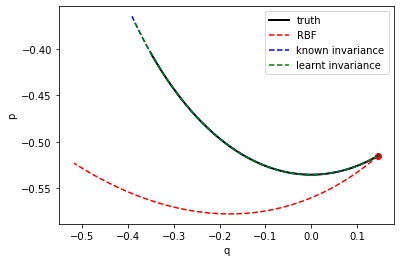

MSE & 0.0060 & 0.0006 & 0.0004
1
0.003943506514745728
0.0017081278397747773
0.002950751432085842


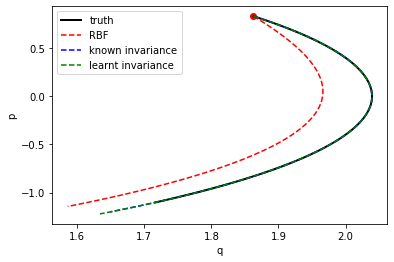

MSE & 0.0050 & 0.0012 & 0.0017
2
0.40000557067160736
0.0013880797565926372
0.004465520759725739


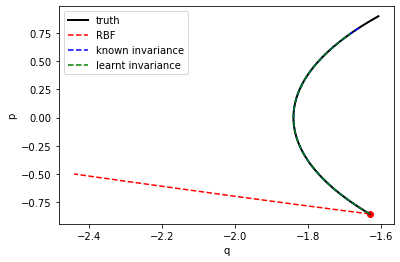

MSE & 0.1367 & 0.0012 & 0.0026
3
0.010764821491991589
0.0001223860790353886
0.00013098285972732855


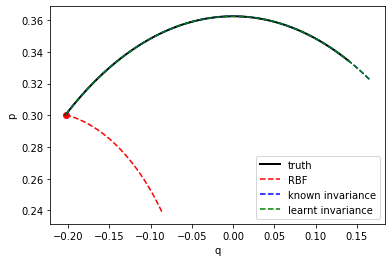

MSE & 0.1052 & 0.0010 & 0.0020
4
0.07488368644837046
0.00010894871055849742
5.303142516244382e-06


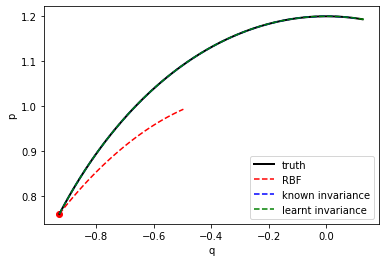

MSE & 0.0991 & 0.0008 & 0.0016
5
0.42921740354909316
0.005145748108992391
0.00839671187634627g


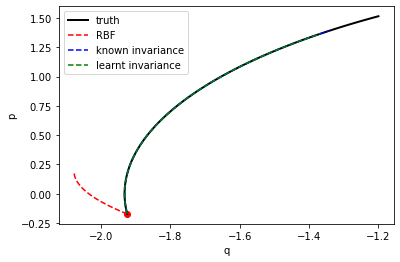

MSE & 0.1541 & 0.0015 & 0.0027
6
0.0016253367116717075
0.0035301078277058307
0.004451015486216359


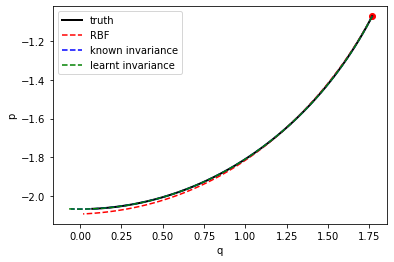

MSE & 0.1324 & 0.0018 & 0.0030
7
0.008017048526344384
0.0022284262501524365
0.0030076846982188318


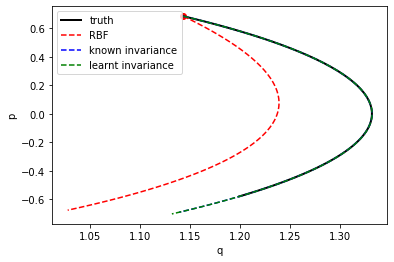

MSE & 0.1168 & 0.0019 & 0.0030
8
0.005309464085719664
0.0024982160890839188
0.001980043502181117


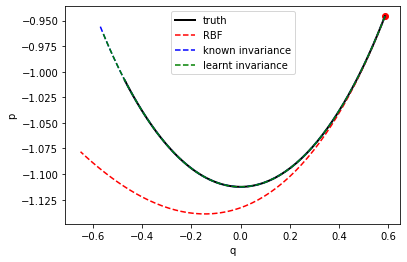

MSE & 0.1044 & 0.0019 & 0.0029
9
0.010398848863451843
0.00016063720522314646
0.0010081038700154468


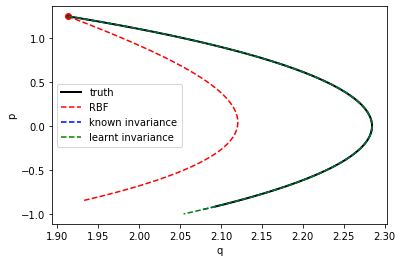

MSE & 0.0950 & 0.0017 & 0.0027


In [17]:


eva_future_moi = []
eva_future_inv = []
eva_future_inv_p = []
eva_future_inv_l = []
eva_future_inv_lp = []

dynamics = SHM_dynamics

# SHM
def energy(X):
    return 0.5*tf.square(X[:,1])+0.5*tf.square(X[:,0])

for i in range(10):
    print(i)
    test_starting_position = (np.random.uniform(-max_x, max_x))
    test_starting_velocity = (np.random.uniform(-max_v, max_v))

    test_starting = (test_starting_position, test_starting_velocity)
    time_setting = (testing_time, time_step)

    evaluate_moi = evaluate_model_future(moi, test_starting, dynamics,time_setting, energy)
    eva_future_moi.append(evaluate_moi[0])
    print(evaluate_moi[0])

    evaluate_invariance =evaluate_model_future(known, test_starting, dynamics,time_setting, energy)
    eva_future_inv.append(evaluate_invariance[0])
    print(evaluate_invariance[0])

    evaluate_invariance_p =evaluate_model_future(model, test_starting, dynamics, time_setting, energy)#, (m.kernel.inv_f, m.kernel.inv_g), (lambda x: x, lambda x:np.sin(x)))
    eva_future_inv_p.append(evaluate_invariance_p[0])
    print(evaluate_invariance_p[0])


    fig, ax = plt.subplots()
    plt.scatter(evaluate_moi[4][0,0],evaluate_moi[4][0,1],color="red")
    plt.plot(evaluate_moi[4][:,0],evaluate_moi[4][:,1], label="truth", color="black", linewidth=2)
    plt.plot(evaluate_moi[1][:,0],evaluate_moi[1][:,1], "--", label='RBF', color="red")
    plt.plot(evaluate_invariance[1][:,0],evaluate_invariance[1][:,1], "--", label="known invariance", color="blue")
    plt.plot(evaluate_invariance_p[1][:,0],evaluate_invariance_p[1][:,1], "--", label="learnt invariance", color="green")
    plt.xlabel("q")
    plt.ylabel("p")
    plt.legend()
    plt.show()
    print("MSE & "+ format((np.mean(eva_future_moi)),".4f")+" & "+format(np.mean(eva_future_inv),".4f")+" & "+format((np.mean(eva_future_inv_p)),".4f"))



In [19]:
print("Log Marginal Likelihood & " + format((moi.log_marginal_likelihood().numpy()),".2f")+" & "+ format((known.log_marginal_likelihood().numpy()),".2f") + " & "+ format((model.log_marginal_likelihood().numpy()),".2f")  +' \\\\')
print("MSE & "+ format((np.mean(eva_future_moi)),".4f")+" & "+format(np.mean(eva_future_inv),".4f")+" & "+format((np.mean(eva_future_inv_p)),".4f")+ ' \\\\')

Log Marginal Likelihood & 67.67 & 82.00 & 79.24 \\
MSE & 0.0950 & 0.0017 & 0.0027 \\


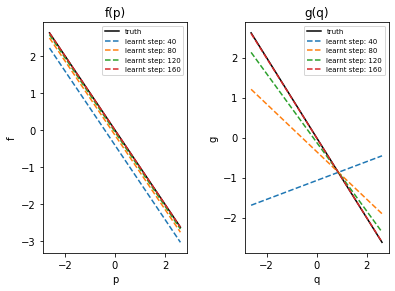

In [28]:

import matplotlib.pyplot as plt
from numpy.polynomial import polynomial
x = np.linspace(-np.radians(150),np.radians(150),100)
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.plot(x, -x, label='truth', color="black")
ax2.plot(x, -x, label='truth', color="black")
ax1.set_title("f(p)")
ax1.set_xlabel("p")
ax1.set_ylabel("f")
ax2.set_title("g(q)")
ax2.set_xlabel("q")
ax2.set_ylabel("g")
for i, (f, g) in enumerate(zip(fs, gs)):
    if i%4==0 and i>3:
        multiplier = -learnt_kernel.f_poly.transform(f[1])
        f = polynomial.Polynomial(np.squeeze(learnt_kernel.f_poly.transform(f)))
        g = polynomial.Polynomial(np.squeeze(learnt_kernel.g_poly.transform(g)))
        ax1.plot(x, f(x)/multiplier, "--", label='learnt step: '+str(i*10))
        ax2.plot(x, g(x)/multiplier, "--", label='learnt step: '+ str(i*10))
ax1.legend(loc=1, prop={"size":7})
ax2.legend(loc=1, prop={"size":7})
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)
plt.savefig("figures/shm_learnt_over_time.pdf")



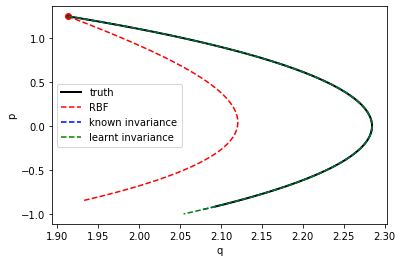

In [30]:

import matplotlib.pyplot as plt
fig, ax = plt.subplots()
plt.scatter(evaluate_moi[4][0,0],evaluate_moi[4][0,1],color="red")
plt.plot(evaluate_moi[4][:,0],evaluate_moi[4][:,1], label="truth", color="black", linewidth=2)
plt.plot(evaluate_moi[1][:,0],evaluate_moi[1][:,1], "--", label='RBF', color="red")
plt.plot(evaluate_invariance[1][:,0],evaluate_invariance[1][:,1], "--", label="known invariance", color="blue")
plt.plot(evaluate_invariance_p[1][:,0],evaluate_invariance_p[1][:,1], "--", label="learnt invariance", color="green")
plt.xlabel("q")
plt.ylabel("p")
plt.legend()
plt.savefig("figures/shm_predicted.pdf")

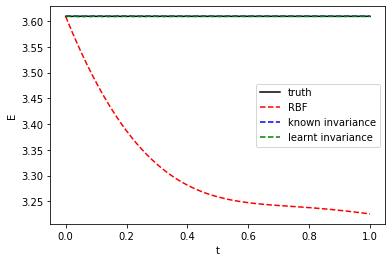

: 

In [31]:
t = np.linspace(0, testing_time, int(testing_time/time_step))
plt.plot(t, tf.squeeze(evaluate_invariance[5])+1, label="truth", color="black")
plt.plot(t, tf.squeeze(evaluate_moi[6])+1, "--", label="RBF", color="red")
plt.plot(t, tf.squeeze(evaluate_invariance[6])+1,"--" ,  label="known invariance", color="blue")
plt.plot(t, tf.squeeze(evaluate_invariance_p[6])+1, "--",label="learnt invariance", color="green")
plt.legend()
plt.xlabel("t")
plt.ylabel("E")
plt.savefig("figures/shm_energy.pdf")

In [ ]:

import importlib, sys
importlib.reload(sys.modules["invariance_functions"])
from invariance_functions import evaluate_model_future